# Three Models Comparison

In this section, we use TF-IDF as the basic feature extraction tool, and compare the effects of Bernoulli model, logistic regression model and support vector machine on the problem of tweet sentiment analysis.

# Import Basic Library

In [2]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import re
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer

## Load Dataset and Display

In [3]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BigData/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

dataset = dataset[['sentiment','text']]
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

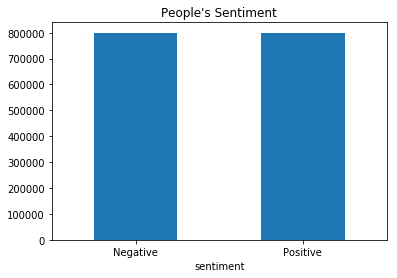

In [9]:
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='People\'s Sentiment',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

text, sentiment = list(dataset['text']), list(dataset['sentiment'])

# Cleaning Data

In [18]:
def data_clean(textdata):
    processedText = []
    
    wordLemm = WordNetLemmatizer()
    
    for tweet in textdata:
        tweet = tweet.lower()       

        tweetwords = ''
        for word in tweet.split():

            if len(word)>1:
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

processedtext = data_clean(text)

# Analysing the Data Set

### Word-Cloud for Negative tweets

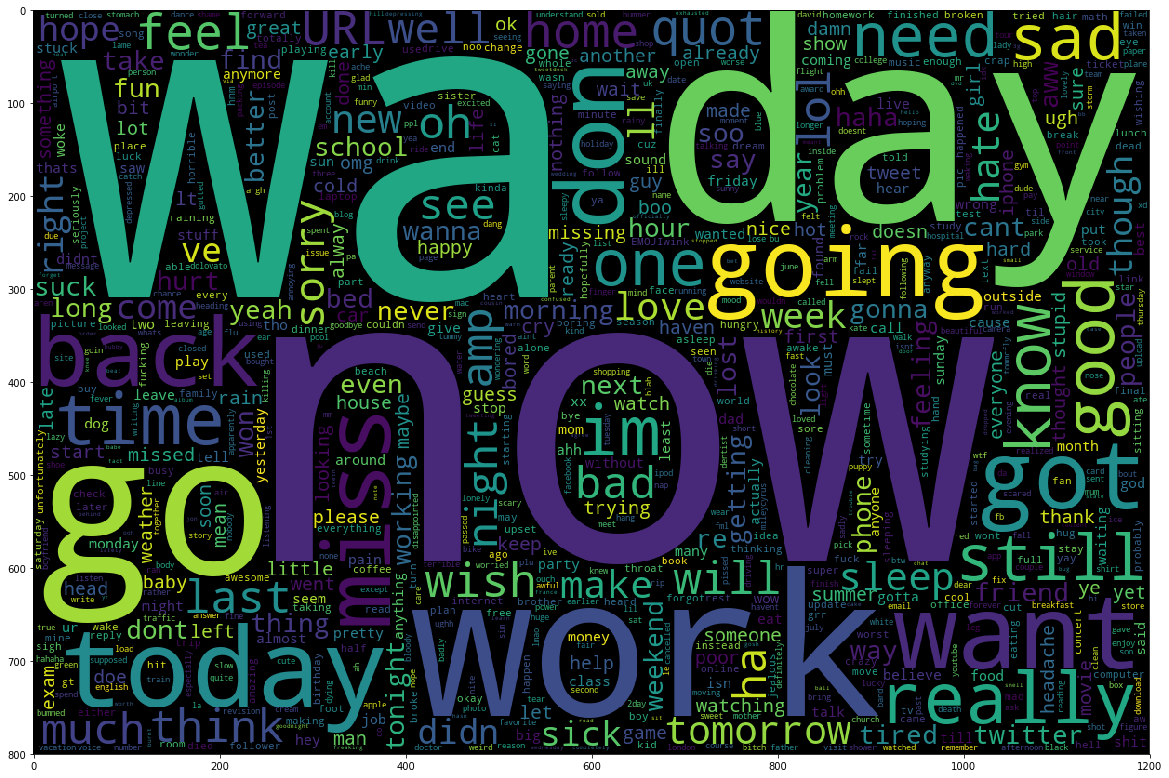

In [19]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 800 , width = 1200 , height = 800, collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Word-Cloud for Positive tweets

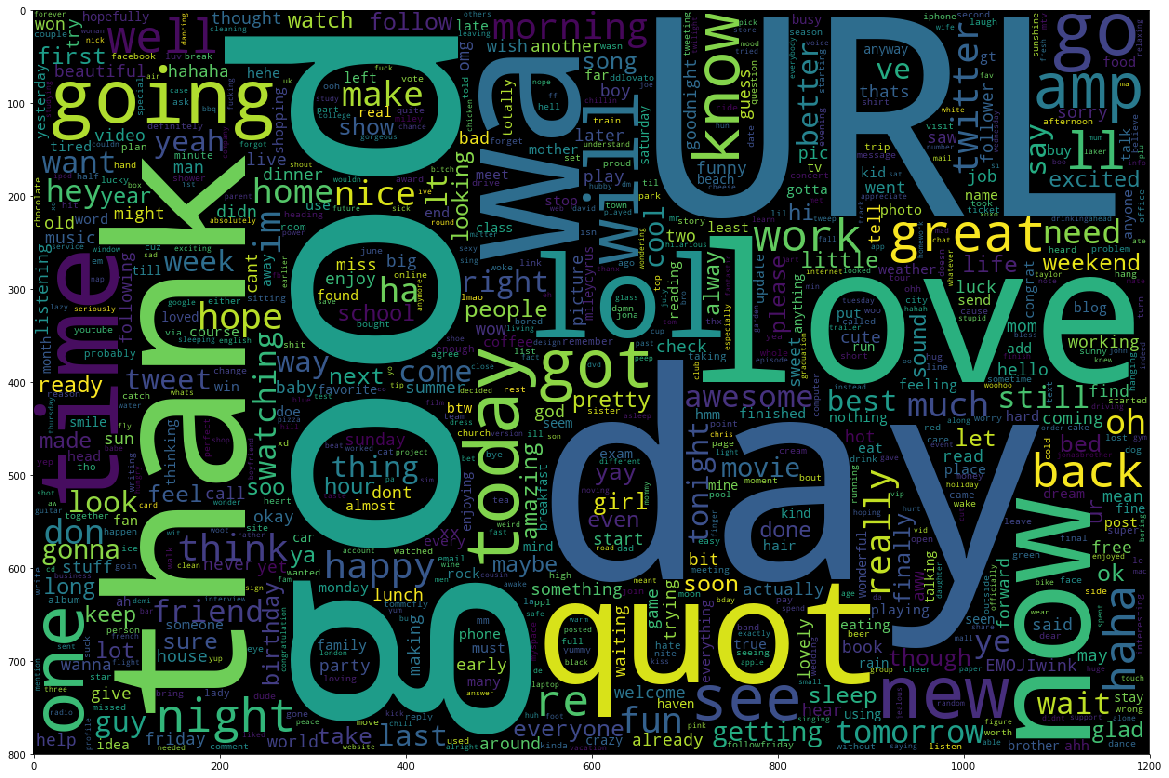

In [20]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 800 , width = 1200 , height = 800, collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

# Split the Dataset

In [21]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size = 0.2, random_state = 0)

# TF-IDF Vectoriser

In [22]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

# Evaluation Module

In [24]:
def evaluation(model):
    
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))
    
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '', xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)

# Creating Models

### 1. BernoulliNB Model

              precision    recall  f1-score   support

           0       0.81      0.79      0.80    159815
           1       0.79      0.81      0.80    160185

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



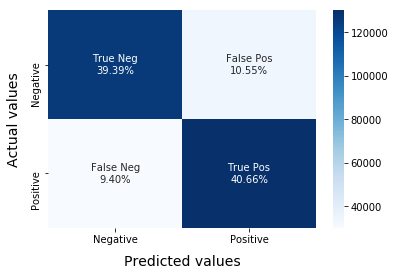

In [26]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
evaluation(BNBmodel)

file = open('bernoulli_model.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

### 2. LinearSVC Model

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    159815
           1       0.81      0.82      0.82    160185

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



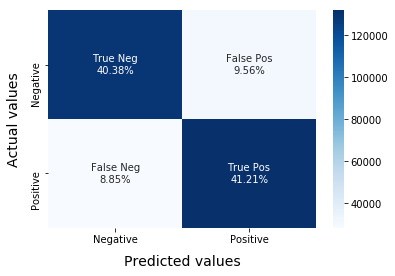

In [27]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
evaluation(SVCmodel)

file = open('SVC_model.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

### 3. Logistic Regression Model

              precision    recall  f1-score   support

           0       0.83      0.82      0.82    159815
           1       0.82      0.83      0.83    160185

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



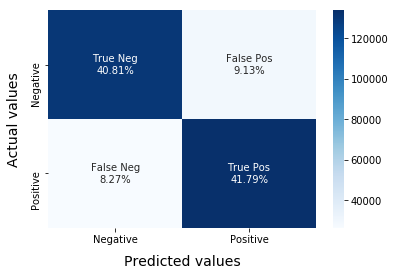

In [29]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
evaluation(LRmodel)

file = open('LR_model.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

# Testing the Model


### 1. Loading Models

In [53]:
def load_model(modelName):
    if modelName == "V":
        file = open('/content/drive/MyDrive/Colab Notebooks/BigData/models/SVC_model.pickle', 'rb')
        SVCmodel = pickle.load(file)
        file.close()
        return SVCmodel

    elif modelName == "L":
        file = open('/content/drive/MyDrive/Colab Notebooks/BigData/models/LR_model.pickle', 'rb')
        LRmodel = pickle.load(file)
        file.close()
        return LRmodel
    
    else:
        file = open('/content/drive/MyDrive/Colab Notebooks/BigData/models/bernoulli_model.pickle', 'rb')
        BNBmodel = pickle.load(file)
        file.close()
        return BNBmodel
    

### 2. Predicting Module

In [44]:
def predictor(vectoriser, model, text):

    textdata = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)
    

    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

### 3. Using Example to Test Models

In [57]:
test_tweets = ["I love Big Data.",
              "I don't like elon mask.",
              "Hey my friend, let's go to central park this weekend.",
              "I am a student in NYU.",
              "She is not my type."
             ]

bnb_model = load_model("B")
df = predictor(vectoriser, bnb_model, test_tweets)
print(df.head())

                                                text sentiment
0                                   I love Big Data.  Positive
1                            I don't like elon mask.  Negative
2  Hey my friend, let's go to central park this w...  Positive
3                             I am a student in NYU.  Positive
4                                She is not my type.  Negative
